### Initialisation

Here we set the google drive access, import the required libraries and load the dataset.

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import tensorflow as tf

from random import randint
from numpy import argmax
import matplotlib

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize
from scipy import stats

from keras import optimizers
from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, ZeroPadding2D, BatchNormalization, Cropping2D
from keras.utils.np_utils import to_categorical
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage

from tqdm import tqdm
from tqdm import tqdm_notebook

import time

Using TensorFlow backend.


In [3]:
# This is to access google drive to load data
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
# crf library from https://github.com/lucasb-eyer/pydensecrf
!pip install '/content/gdrive/My Drive/pydensecrf'

Processing ./gdrive/My Drive/pydensecrf
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp36-cp36m-linux_x86_64.whl size=2235079 sha256=0cfb142ca42a85f70fcfaad487cc68bec6e9537758579b37919fbdd6e7798088
  Stored in directory: /tmp/pip-ephem-wheel-cache-8pfklraz/wheels/80/c5/63/916bb868352090a8237bc17772193c17f16ee3d29acb7f4396
Successfully built pydensecrf
  Found existing installation: pydensecrf 1.0rc2
    Uninstalling pydensecrf-1.0rc2:
      Successfully uninstalled pydensecrf-1.0rc2


In [0]:
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
%matplotlib inline

In [0]:
def crf(mask_img, sxy, compat):
    """
    Function which returns the labelled image after applying CRF:
    
    mask_img = Which has been labelled by some technique..
    sxy = theta
    compat = w
    """
    
    
    annotated_label = mask_img[:,:] 
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 5
    
    # Setting up the CRF model
    d = dcrf.DenseCRF2D(mask_img.shape[1], mask_img.shape[0], n_labels)

    # Get unary-potentials
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # Add Pairwise Potentials 
    d.addPairwiseGaussian(sxy=sxy, compat=compat, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)

    #Run Inference for 20 steps 
    Q = d.inference(20)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((mask_img.shape[0],mask_img.shape[1]))

In [0]:
def test_accuracy_score(prediction, actual_labels):
  "plots accuracy of each label and the overall accuracy"
  if (prediction.shape[0:3] != actual_labels.shape[0:3]): print("shape of inputs do not match"); return 0;
  
  # Pixelwise accuracy score
  Num0=0; Num1=0; Num2=0; Num3=0; Num4=0;
  error0=0; error1=0; error2=0; error3=0; error4=0;
  for i in range(prediction.shape[0]):
    for j in range(prediction.shape[1]):
      for k in range(prediction.shape[2]):
        if actual_labels[i,j,k] == 0:
          Num0 += 1
          if (actual_labels[i,j,k] != prediction[i,j,k]): error0 += 1;
        
        if actual_labels[i,j,k,0] == 1:
          Num1 += 1
          if (actual_labels[i,j,k,0] != prediction[i,j,k]): error1 += 1;
        
        if actual_labels[i,j,k,0] == 2: 
          Num2 += 1
          if (actual_labels[i,j,k,0] != prediction[i,j,k]): error2 += 1;
         
        if actual_labels[i,j,k,0] == 3:
          Num3 += 1
          if (actual_labels[i,j,k,0] != prediction[i,j,k]): error3 += 1;
        
        if actual_labels[i,j,k,0] == 4:
          Num4 += 1
          if (actual_labels[i,j,k,0] != prediction[i,j,k]): error4 += 1;
  
  total_error = error0 + error1 + error2 + error3 + error4
  percentage_error = total_error/(prediction.shape[0]*prediction.shape[1]*prediction.shape[2])
  Overall_accuracy = 1 - percentage_error
  label0_accuracy  = 1 - error0/Num0
  label1_accuracy  = 1 - error1/Num1
  label2_accuracy  = 1 - error2/Num2
  label3_accuracy  = 1 - error3/Num3
  label4_accuracy  = 1 - error4/Num4
  
  # All the plots
  fig = plt.figure(figsize=(16, 2))
  #plt.subplot(321)
  plt.ylim(0.75, 1)
  plt.bar(["overall", "label0", "label1", "label2", "label3", "label4"], [Overall_accuracy, label0_accuracy, label1_accuracy, label2_accuracy, label3_accuracy, label4_accuracy], align='center')
  plt.ylabel("Accuracy")
  fig = plt.figure(figsize=(10, 60))
  fig.tight_layout()
  
  print ("overall accuracy is ", Overall_accuracy)
  print ("label0 accuracy is " , label0_accuracy)
  print ("label1 accuracy is " , label1_accuracy)
  print ("label2 accuracy is " , label2_accuracy)
  print ("label3 accuracy is " , label3_accuracy)
  print ("label4 accuracy is " , label4_accuracy)
  
  return [Overall_accuracy, label0_accuracy, label1_accuracy, label2_accuracy, label3_accuracy, label4_accuracy]


#iou error
def iou_accuracy(prediction, actual_labels):
  with tf.Session() as sess:
      ypredT = tf.constant(prediction)
      ytrueT = tf.constant(actual_labels)
      iou,conf_mat = tf.metrics.mean_iou(ytrueT, ypredT, num_classes=5)
      sess.run(tf.local_variables_initializer())
      sess.run([conf_mat])
      miou = sess.run([iou])
      print(miou)

In [0]:
# load seismic amplitudes and corresponding labels (100 inlines)
#!cp "/content/gdrive/My Drive/Forties/data/malenov/CNN_data/De_noised_Seismic_cube_Forties___9_1561024414129.sgy" "De_noised_Seismic_cube_Forties___9_1561024414129.sgy"
#!cp "/content/gdrive/My Drive/Forties/data/malenov/CNN_data/Por_Labels_1562324680441.sgy" "Por_Labels_1562324680441.sgy"
# 400 inlines
!cp "/content/gdrive/My Drive/Forties/data/malenov/CNN_data/De_noised_Seismic___9_1562332244893.sgy" "De_noised_Seismic_cube_Forties___9_1561024414129.sgy"
!cp "/content/gdrive/My Drive/Forties/data/malenov/CNN_data/Por_Labels_1562331649850.sgy" "Por_Labels_1562324680441.sgy"

In [9]:
!pip install segyio

In [0]:
# Load the dataset
import scipy.misc
import os
#os.chdir("../")
import segyio
import numpy as np
from shutil import copyfile

# Amplitudes
sgycube = 'De_noised_Seismic_cube_Forties___9_1561024414129.sgy'
# Labels
sgylabels = 'Por_Labels_1562324680441.sgy'

amplitude_inlines = []
with segyio.open(sgycube, "r") as segyfile:

    # Memory map file for faster reading (especially if file is big...)
    segyfile.mmap()
    
    for inline in segyfile.ilines:
        amplitude_inlines.append(segyfile.iline[inline])

amplitude_inlines = np.array(amplitude_inlines)

# original cube amplitudes
# --- 
original_cube_amplitudes = np.copy(amplitude_inlines)
# ---

label_inlines = []
with segyio.open(sgylabels, "r") as segyfile:

    # Memory map file for faster reading (especially if file is big...)
    segyfile.mmap()
    
    for inline in segyfile.ilines:
        label_inlines.append(segyfile.iline[inline])

label_inlines = np.array(label_inlines)

# original cube labels
# --- 
original_cube_labels = np.copy(label_inlines)
# --- 

# -----> Remove below for binary classification (this is an ad-hoc labelling for our dataset only)
# There were some NAN labels in the original labels (at the very bottom and top of the images)
# label NaNs in labels as either 1 or 5
# ---
for i in range(original_cube_labels.shape[0]):
    for k in range(original_cube_labels.shape[2]):
         
        if (k>230):
            original_cube_labels[i,:,k] = 5
        if (k<50):
            original_cube_labels[i,:,k] = 1
# ---
original_cube_labels_4D = original_cube_labels.reshape(401, 401, 251, 1)


## Combining Best Models (2 FCN and SWC) + CRF

In [0]:
# FCN 0.987 accuracy
predicted_cube1 = np.load('/content/gdrive/My Drive/FCN Approach/combined_prediction1.npy')
# FCN 0.9856 accuracy
predicted_cube2 = np.load('/content/gdrive/My Drive/FCN Approach/combined_prediction2.npy')
# SWC 0.9894 accuracy
predicted_cube3 = np.load('/content/gdrive/My Drive/FCN Approach/combined_prediction3.npy')


In [0]:
# model avarage the predictions above
all_predictions = np.array([predicted_cube1[:,:,:], predicted_cube2[:,:,:], predicted_cube3[:,:,:]])
combined_prediction = stats.mode(all_predictions)
combined_prediction = combined_prediction[0][0]

In [0]:
# This is to spare some memory so that the session do not crash
del predicted_cube1
del predicted_cube2
del predicted_cube3

overall accuracy is  0.9895522790028436
label0 accuracy is  0.9985925865214078
label1 accuracy is  0.9296991809338351
label2 accuracy is  0.9713791789326013
label3 accuracy is  0.9514959056858777
label4 accuracy is  0.9964133013225788


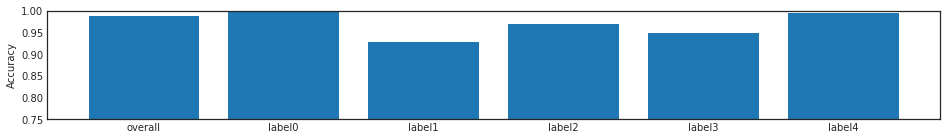

<Figure size 720x4320 with 0 Axes>

In [22]:
test_accuracy = test_accuracy_score(combined_prediction, original_cube_labels_4D-1)

In [0]:
# Apply crf to entire cube in 2 axis
CRF_Cube = np.zeros(combined_prediction.shape)

for i in range(combined_prediction.shape[0]):
  crf_smoothed_inline = crf(combined_prediction[i,:,:], (2,2), 6)
  CRF_Cube[i,:,:] = crf_smoothed_inline

for i in range(combined_prediction.shape[1]):
  crf_smoothed_inline = crf(CRF_Cube[:,i,:], (2,2), 6)
  CRF_Cube[:,i,:] = crf_smoothed_inline

In [0]:
# Save
# np.save('/content/gdrive/My Drive/FCN Approach/combined_3predictions_after_CRF.npy', combined_prediction)

overall accuracy is  0.9895783685117615
label0 accuracy is  0.99859392714734
label1 accuracy is  0.9292528792319313
label2 accuracy is  0.9714147190255483
label3 accuracy is  0.9518363505338124
label4 accuracy is  0.9964310727634386


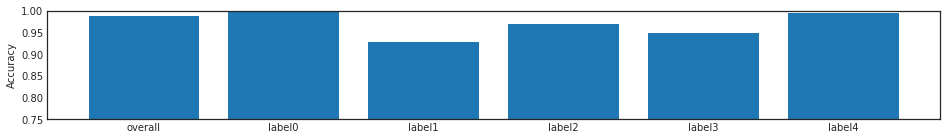

<Figure size 720x4320 with 0 Axes>

In [15]:
test_accuracy2 = test_accuracy_score(CRF_Cube, original_cube_labels_4D-1)